In [1]:
import calibration
import pandas as pd
from astropy import units as u
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Manual reduction to csv

In [10]:
def update_log_entry(logfile_path, date, target_freq, target_flux, coeff, sun_projection_on_chime):
    height, center, width, baseline = coeff
    df = pd.read_csv(logfile_path)
    update_mask = np.where((df["date"] == date) & (df["target_freq"] == target_freq))
    for index in update_mask[0]:
        df.loc[index, "fit_success"] = False

    new_row_data = [date,target_freq,target_flux,height,center,width,baseline,sun_projection_on_chime,True]
    df.loc[len(df)] = new_row_data
    df.to_csv(logfile_path, index=False)    

In [55]:
date = "2024_291"
data_dir = f"/home/scratch/dbautist/CHIME_temp/{date}/"
fit_frequency = 410
outdir = "/home/scratch/dbautist/TEST/debug/"


# fit_frequency = 610
data_grid, frequency, timestamps = calibration.load_CHIME_data(data_dir)
start_time = timestamps[0]

if fit_frequency == 610:
    index = np.argmin(np.abs(frequency - 610))
    flux = calibration.median_610
elif fit_frequency == 410:
    index = np.argmin(np.abs(frequency - 410))
    flux = calibration.median_410
else:
    print("please set fit_frequency to either 610 or 410 MHz")


(0.0, 100000000.0)

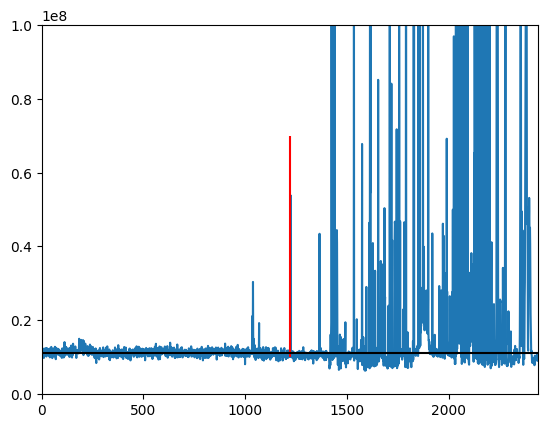

In [56]:
lower = 0
upper = len(data_grid)

closest_approach_index = upper // 2

full_median = np.median(data_grid[lower:upper, index])

plt.figure()
xx = np.arange(lower, upper)
plt.plot(xx, data_grid[lower:upper, index])
plt.vlines(closest_approach_index, 1e7, 7e7, color="red")
plt.hlines(full_median, xx.min(), xx.max(), color="black")
plt.xlim(lower, upper)
plt.ylim(0, 1e8)

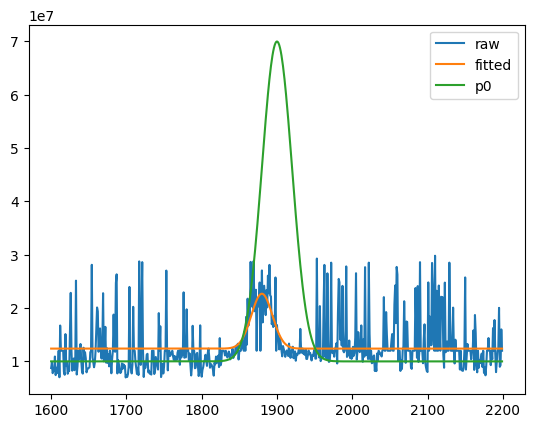

In [61]:
center_guess = 1900
lower = max((0, center_guess - 300))
upper = min((center_guess + 300, len(data_grid)-1))


ydata = data_grid[lower:upper, index].copy()
xdata = np.arange(lower, upper)

mask = np.where(ydata > 3e7)#np.where(ydata > 1e9)
ydata[mask] = np.median(ydata)
xx = np.linspace(lower, upper, num=len(ydata))#np.arange(lower, upper) # may need to be linspace

# define guessing parameters
bounds = ((0,np.min(xx),3,0), (1e9, np.max(xx), 100, np.inf))
p0 = (6e7, center_guess, 20, 1e7)
    
# fit gaussian and calibrate based on fit values
coeff, cov = curve_fit(calibration.gaussian, xx, ydata, p0=p0, bounds=bounds)
# coeff[3] = full_median
plt.figure()
plt.plot(xdata, ydata, label="raw")
plt.plot(xdata, calibration.gaussian(xdata, *coeff), label='fitted')
plt.plot(xdata, calibration.gaussian(xdata, *p0), label='p0')
# plt.xlim(1810, 1950)
# plt.ylim(0, 5e8)
plt.legend()
# plt.ylim(0, 2e8)

In [62]:
height, center, width, baseline = coeff
sun_df = pd.read_csv(f"/users/dbautist/CHIME_landing_directory/sunPosition/{date}_CHIME.csv")

closest_approach_index = calibration.get_closest_position(sun_df, timestamps)

sun_alt, sun_az = calibration.solar_position(timestamps[closest_approach_index], lat=calibration.CHIME_latitude, lon=calibration.CHIME_longitude, unit=u.deg)
sun_vector =      calibration.normal_vector(sun_az, sun_alt, degrees=True)
chime_vector =    calibration.normal_vector(calibration.CHIME_azimuth, calibration.CHIME_altitude, degrees=True)

sun_projection_on_chime = np.dot(sun_vector, chime_vector)
projected_flux = flux * sun_projection_on_chime

counts_to_flux = projected_flux / height
calibrated_grid = data_grid * counts_to_flux
labels = ['height', 'center', 'width', 'baseline']
for i in range(len(coeff)):
    print(f"{labels[i]}: {coeff[i]}")
print(f"counts to flux: {counts_to_flux}")

height: 10294052.122871377
center: 1879.941278541409
width: 13.993271753020158
baseline: 12399602.131929548
counts to flux: 0.024131172921255915


In [63]:
print(f"sun projection: {sun_projection_on_chime}")
print(f"closest approach: {timestamps[closest_approach_index]} UTC")

sun projection: 0.506954187423328
closest approach: 2024-10-17 19:42:13.472779+00:00 UTC


In [64]:
import gui_reduction

logfile_path = "/home/scratch/dbautist/CHIME_temp/calibration_log.csv"
datetime = [start_time] * 1024
mean_spectrum = np.nanmean(calibrated_grid, axis=0)

data_dict = {"datetime":datetime, "intensity":mean_spectrum, "frequency":frequency*1e6}
df = pd.DataFrame(data_dict)

gui_reduction.check_dir(f"{outdir}/{date}/")
df.to_csv(f"{outdir}/{date}/{date}.csv", index=False)
update_log_entry(logfile_path, date, fit_frequency, flux, coeff, sun_projection_on_chime)
print(f"written to {outdir}/{date}/{date}.csv")

written to /home/scratch/dbautist/TEST/debug//2024_291/2024_291.csv
